# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
train = pd.read_csv('train.csv')
train.shape

(381109, 12)

In [4]:
test = pd.read_csv('test.csv')
test.shape

(127037, 11)

In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:
train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

# Data Preprocessing
* Convert the categorical features
* Divide the numerical features into bins
* Drop the unnecessary columns

In [8]:
train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [9]:
train['Driving_License'].unique()

array([1, 0])

In [10]:
train['Previously_Insured'].unique()

array([0, 1])

In [11]:
train['Region_Code'].unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

In [12]:
train['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [13]:
train['Policy_Sales_Channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

In [14]:
train['Vehicle_Damage'].unique()

array(['Yes', 'No'], dtype=object)

Annual Premium could also be divided into bins

In [ ]:
def data_prep(data):
    data = data.drop(columns=['id', 'Vintage'], axis=1)
    cols = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
    data = pd.get_dummies(data,columns=cols, drop_first=True)
    data['Age'] = pd.cut(data['Age'], bins=[0,29,35,50,100])
    data['Age'] = data['Age'].cat.codes
    return data

In [ ]:
train_dum = data_prep(train)
test_dum = data_prep(test)

In [ ]:
train_dum.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Response,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,2,1,28.0,0,40454.0,26.0,1,1,1,0,1
1,3,1,3.0,0,33536.0,26.0,0,1,0,0,0
2,2,1,28.0,0,38294.0,26.0,1,1,1,0,1
3,0,1,11.0,1,28619.0,152.0,0,1,0,1,0
4,0,1,41.0,1,27496.0,152.0,0,0,0,1,0


In [ ]:
test_dum.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,0,1,11.0,1,35786.0,152.0,1,0,1,0
1,2,1,28.0,0,33762.0,7.0,1,1,0,0
2,2,1,28.0,0,40050.0,124.0,1,1,0,0
3,0,1,27.0,1,37356.0,152.0,1,1,1,0
4,0,1,28.0,1,59097.0,152.0,1,0,1,0


### Gender

In [15]:
x_train_gender = train['Gender'].apply(lambda x: 1 if x=='Male' else 0)
x_train_gender = x_train_gender.values.reshape(-1, 1)

x_test_gender = test['Gender'].apply(lambda x:1 if x=='Male' else 0)
x_test_gender = x_test_gender.values.reshape(-1, 1)

print(x_train_gender.shape)
print(x_test_gender.shape)

(381109, 1)
(127037, 1)


### Age

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

scaler.fit(train['Age'].values.reshape(-1,1))
x_train_age = scaler.transform(train['Age'].values.reshape(-1,1))
x_test_age = scaler.transform(test['Age'].values.reshape(-1,1))

print(x_train_age.shape)
print(x_test_age.shape)

(381109, 1)
(127037, 1)


In [18]:
x_train_age_n = train['Age'].values.reshape(-1,1)
x_test_age_n = test['Age'].values.reshape(-1,1)

print(x_train_age_n.shape)
print(x_test_age_n.shape)

(381109, 1)
(127037, 1)


Feature engineering: new categorical feature for Age

In [19]:
x_train_age_cat = train['Age'].apply(lambda x:1 if x>=30 else 0)
x_train_age_cat = x_train_age_cat.values.reshape(-1, 1)

x_test_age_cat = test['Age'].apply(lambda x:1 if x>=30 else 0)
x_test_age_cat = x_test_age_cat.values.reshape(-1, 1)

print(x_train_age_cat.shape)
print(x_test_age_cat.shape)

(381109, 1)
(127037, 1)


### Driving License

In [20]:
x_train_license = train['Driving_License'].values.reshape(-1, 1)
x_test_license = test['Driving_License'].values.reshape(-1, 1)

print(x_train_license.shape)
print(x_test_license.shape)

(381109, 1)
(127037, 1)


### Region Code

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
encoder = OneHotEncoder()
encoder.fit(train["Region_Code"].values.reshape(-1, 1))

x_train_region_code = encoder.transform(train['Region_Code'].values.reshape(-1, 1))
x_test_region_code = encoder.transform(test['Region_Code'].values.reshape(-1, 1))

print(x_train_region_code.shape)
print(x_test_region_code.shape)

(381109, 53)
(127037, 53)


In [23]:
train['Region_Code'].value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

in response coding, when we calculate the probability of a feature value belonging to a particular class

In [24]:
def get_feature_dict(feature):
    value_counts = train[feature].value_counts()
    my_dict = dict()
    for i, denominator in value_counts.items():
        class_count = train[(train['Response']==1) & (train[feature]==i)]
        my_dict[i] = round((class_count.shape[0]/ denominator), 6)
    return my_dict

In [25]:
region_code_dict = get_feature_dict('Region_Code')
region_code_dict

{0.0: 0.086096,
 1.0: 0.108135,
 2.0: 0.071075,
 3.0: 0.127662,
 4.0: 0.158245,
 5.0: 0.115715,
 6.0: 0.069904,
 7.0: 0.131747,
 8.0: 0.096142,
 9.0: 0.081587,
 10.0: 0.060128,
 11.0: 0.11276,
 12.0: 0.097561,
 13.0: 0.090188,
 14.0: 0.090209,
 15.0: 0.071987,
 16.0: 0.066766,
 17.0: 0.07031,
 18.0: 0.131574,
 19.0: 0.162866,
 20.0: 0.115245,
 21.0: 0.071027,
 22.0: 0.063407,
 23.0: 0.153061,
 24.0: 0.141615,
 25.0: 0.042749,
 26.0: 0.072284,
 27.0: 0.074035,
 28.0: 0.187163,
 29.0: 0.123362,
 30.0: 0.073825,
 31.0: 0.10051,
 32.0: 0.085755,
 33.0: 0.099294,
 34.0: 0.075721,
 35.0: 0.124604,
 36.0: 0.079914,
 37.0: 0.079258,
 38.0: 0.192004,
 39.0: 0.1236,
 40.0: 0.118147,
 41.0: 0.121776,
 42.0: 0.07445,
 43.0: 0.092459,
 44.0: 0.040842,
 45.0: 0.109723,
 46.0: 0.102891,
 47.0: 0.087682,
 48.0: 0.101901,
 49.0: 0.074782,
 50.0: 0.062677,
 51.0: 0.153005,
 52.0: 0.123596}

In [26]:
pkn = test['Region_Code'].copy()
pkn = pkn.apply(lambda x: region_code_dict[x])
pkn

0         0.112760
1         0.187163
2         0.187163
3         0.074035
4         0.187163
            ...   
127032    0.079258
127033    0.187163
127034    0.102891
127035    0.187163
127036    0.123362
Name: Region_Code, Length: 127037, dtype: float64

In [27]:
x_train_region_code_resp = train['Region_Code'].apply(lambda x:region_code_dict[x])
x_train_region_code_resp = x_train_region_code_resp.values.reshape(-1, 1)

x_test_region_code_resp = test['Region_Code'].apply(lambda x: region_code_dict[x] 
                                                    if x in region_code_dict.keys() 
                                                    else np.median(list(region_code_dict.values())))
x_test_region_code_resp = x_test_region_code_resp.values.reshape(-1, 1)

print(x_train_region_code_resp.shape)
print(x_test_region_code_resp.shape)

(381109, 1)
(127037, 1)


### Previously Insured

In [28]:
x_train_prev_ins = train['Previously_Insured'].values.reshape(-1, 1)
x_test_prev_ins = test['Previously_Insured'].values.reshape(-1, 1)

print(x_train_prev_ins.shape)
print(x_test_prev_ins.shape)

(381109, 1)
(127037, 1)


### Vehice Age

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
encoder = OneHotEncoder()
encoder.fit(train['Vehicle_Age'].values.reshape(-1, 1))

x_train_vehicle_age = encoder.transform(train['Vehicle_Age'].values.reshape(-1, 1))
x_test_vehicle_age = encoder.transform(test['Vehicle_Age'].values.reshape(-1, 1))

print(x_train_vehicle_age.shape)
print(x_test_vehicle_age.shape)

(381109, 3)
(127037, 3)


label encoding 'Vehicle Age'

In [31]:
x_train_vehicle_age_n = train["Vehicle_Age"].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
x_train_vehicle_age_n = x_train_vehicle_age_n.values.reshape(-1, 1)

x_test_vehicle_age_n = test["Vehicle_Age"].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
x_test_vehicle_age_n = x_test_vehicle_age_n.values.reshape(-1, 1)

Response Coding

In [32]:
vehicle_age_dict = get_feature_dict('Vehicle_Age')
vehicle_age_dict

{'1-2 Year': 0.173755, '< 1 Year': 0.043705, '> 2 Years': 0.293746}

In [33]:
x_train_vehicle_age_resp = train['Vehicle_Age'].apply(lambda x: vehicle_age_dict[x])
x_train_vehicle_age_resp = x_train_vehicle_age_resp.values.reshape(-1, 1)

x_test_vehicle_age_resp = test['Vehicle_Age'].apply(lambda x: vehicle_age_dict[x])
x_test_vehicle_age_resp = x_test_vehicle_age_resp.values.reshape(-1, 1)

print(x_train_vehicle_age_resp.shape)
print(x_test_vehicle_age_resp.shape)

(381109, 1)
(127037, 1)


### Vehicle Damage

In [34]:
x_train_damage = train['Vehicle_Damage'].apply(lambda x: 1 if x=='Yes' else 0)
x_train_damage = x_train_damage.values.reshape(-1, 1)

x_test_damage = test['Vehicle_Damage'].apply(lambda x: 1 if x=='Yes' else 0)
x_test_damage = x_test_damage.values.reshape(-1, 1)

print(x_train_damage.shape)
print(x_test_damage.shape)

(381109, 1)
(127037, 1)


### Annual Premium

In [35]:
scaler = MinMaxScaler()
scaler.fit(train['Annual_Premium'].values.reshape(-1, 1))
x_train_premium = scaler.transform(train['Annual_Premium'].values.reshape(-1, 1))
x_test_premium = scaler.transform(test['Annual_Premium'].values.reshape(-1, 1))

print(x_train_premium.shape)
print(x_test_premium.shape)

(381109, 1)
(127037, 1)


In [36]:
x_train_premium_n = train['Annual_Premium'].values.reshape(-1, 1)
x_test_premium_n = test['Annual_Premium'].values.reshape(-1, 1)

print(x_train_premium_n.shape)
print(x_test_premium_n.shape)

(381109, 1)
(127037, 1)


### Policy Sales Channel

In [37]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(train['Policy_Sales_Channel'].values.reshape(-1, 1))

x_train_sales_chnl = encoder.transform(train['Policy_Sales_Channel'].values.reshape(-1, 1))
x_test_sales_chnl = encoder.transform(test['Policy_Sales_Channel'].values.reshape(-1, 1))

print(x_train_sales_chnl.shape)
print(x_test_sales_chnl.shape)

(381109, 155)
(127037, 155)


Response Encoding

In [38]:
sales_chnl_dict = get_feature_dict('Policy_Sales_Channel')
sales_chnl_dict

{1.0: 0.032588,
 2.0: 0.25,
 3.0: 0.304015,
 4.0: 0.200393,
 6.0: 0.0,
 7.0: 0.113892,
 8.0: 0.082508,
 9.0: 0.100592,
 10.0: 0.189394,
 11.0: 0.089776,
 12.0: 0.168582,
 13.0: 0.147453,
 14.0: 0.101286,
 15.0: 0.087838,
 16.0: 0.086042,
 17.0: 0.1875,
 18.0: 0.035928,
 19.0: 0.085586,
 20.0: 0.111111,
 21.0: 0.081081,
 22.0: 0.054217,
 23.0: 0.137441,
 24.0: 0.132,
 25.0: 0.199675,
 26.0: 0.199385,
 27.0: 0.333333,
 28.0: 0.333333,
 29.0: 0.125741,
 30.0: 0.110638,
 31.0: 0.253566,
 32.0: 0.095238,
 33.0: 0.0,
 34.0: 0.0,
 35.0: 0.133333,
 36.0: 0.326923,
 37.0: 0.098684,
 38.0: 0.0,
 39.0: 0.1,
 40.0: 0.133333,
 41.0: 0.0,
 42.0: 0.19697,
 43.0: 1.0,
 44.0: 0.19802,
 45.0: 0.148936,
 46.0: 0.0,
 47.0: 0.126984,
 48.0: 0.05,
 49.0: 0.142857,
 50.0: 0.0,
 51.0: 0.083333,
 52.0: 0.109005,
 53.0: 0.21875,
 54.0: 0.16,
 55.0: 0.149525,
 56.0: 0.184615,
 57.0: 0.2,
 58.0: 0.111111,
 59.0: 0.19685,
 60.0: 0.102515,
 61.0: 0.096718,
 62.0: 0.166667,
 63.0: 0.052632,
 64.0: 0.05618,
 65.0: 0.

In [39]:
x_train_sales_chnl_resp = train['Policy_Sales_Channel'].apply(lambda x: sales_chnl_dict[x])
x_train_sales_chnl_resp = x_train_sales_chnl_resp.values.reshape(-1, 1)

x_test_sales_chnl_resp = test['Policy_Sales_Channel'].apply(lambda x: sales_chnl_dict[x] if x in sales_chnl_dict.keys() 
                                                                                              else np.median(list(sales_chnl_dict.values())))
x_test_sales_chnl_resp = x_test_sales_chnl_resp.values.reshape(-1, 1)

print(x_train_sales_chnl_resp.shape)
print(x_test_sales_chnl_resp.shape)

(381109, 1)
(127037, 1)


### Vinatge

In [40]:
scaler = MinMaxScaler()
scaler.fit(train['Vintage'].values.reshape(-1, 1))
x_train_vintage = scaler.transform(train['Vintage'].values.reshape(-1, 1))
x_test_vintage = scaler.transform(test['Vintage'].values.reshape(-1, 1))

print(x_train_vintage.shape)
print(x_test_vintage.shape)

(381109, 1)
(127037, 1)


In [41]:
x_train_vintage_n = train['Vintage'].values.reshape(-1, 1)
x_test_vintage_n =  test['Vintage'].values.reshape(-1, 1)

print(x_train_vintage_n.shape)
print(x_test_vintage_n.shape)

(381109, 1)
(127037, 1)


# Stacking all features together

### Set 1: Label Encoded + One Hot encoded categorical features + scaled numerical features

In [62]:
y_train_all = train['Response'].values

In [45]:
from scipy.sparse import hstack

x_train_ohe = hstack((x_train_gender, x_train_age, x_train_license, 
                      x_train_region_code, x_train_prev_ins, 
                       x_train_vehicle_age, x_train_damage, 
                      x_train_premium, x_train_sales_chnl, x_train_vintage))

x_test_ohe = hstack((x_test_gender, x_test_age, x_test_license, 
                     x_test_region_code, x_test_prev_ins, 
                      x_test_vehicle_age, x_test_damage, 
                     x_test_premium, x_test_sales_chnl, x_test_vintage)) 

print("train data shape:", (x_train_ohe.shape, y_train.shape))
print("test data shape:", x_test_ohe.shape)

train data shape: ((381109, 218), (381109,))
test data shape: (127037, 218)


### Set 2: Label Encoded + Response encoded categorical features + Numerical features

In [46]:
x_train_r = np.hstack((x_train_gender, x_train_age_n, x_train_age_cat, x_train_license, 
                       x_train_region_code_resp, x_train_prev_ins, 
                       x_train_vehicle_age_resp, x_train_damage, x_train_premium_n, 
                       x_train_sales_chnl_resp, x_train_vintage_n))

x_test_r = np.hstack((x_test_gender, x_test_age_n, x_test_age_cat, x_test_license, 
                      x_test_region_code_resp, x_test_prev_ins, 
                      x_test_vehicle_age_resp, x_test_damage, x_test_premium_n, 
                      x_test_sales_chnl_resp, x_test_vintage_n)) 

print("train data shape:", (x_train_r.shape, y_train.shape))
print("test data shape:", x_test_r.shape)

train data shape: ((381109, 11), (381109,))
test data shape: (127037, 11)


# Train-Validation Split

In [ ]:
inputs = train_dum.drop('Response', axis=1)
targets = train_dum['Response']

x_test = test_dum.copy()

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
skf = StratifiedKFold(n_splits=10)

for train_idx, val_idx in skf.split(inputs, targets):
    x_train, x_val = inputs.iloc[train_idx], inputs.iloc[val_idx]
    y_train, y_val = targets.iloc[train_idx], targets.iloc[val_idx]

# Building ML models

## With Set 1 features

### Logistic Regression with SGD

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [48]:
sgd = SGDClassifier(loss = 'log', class_weight='balanced')
parameter = {'alpha':[0.001, 0.01, 0.1]}
clf =GridSearchCV(sgd, parameter, cv=5, scoring='roc_auc', n_jobs=-1,
                  return_train_score=True)
clf.fit(x_train_ohe, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(class_weight='balanced', loss='log'),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.01, 0.1]},
             return_train_score=True, scoring='roc_auc')

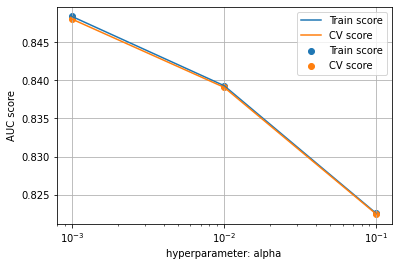

In [49]:
train_loss = clf.cv_results_['mean_train_score']
cv_loss = clf.cv_results_['mean_test_score']
plt.plot(parameter['alpha'], train_loss, label='Train score')
plt.plot(parameter['alpha'], cv_loss, label='CV score')

plt.scatter(parameter['alpha'], train_loss, label='Train score')
plt.scatter(parameter['alpha'], cv_loss, label='CV score')
plt.xscale('log')

plt.legend()
plt.xlabel('hyperparameter: alpha')
plt.ylabel("AUC score")
plt.grid()
plt.show()

with only L1 regularization

In [50]:
sgd = SGDClassifier(loss='log', class_weight='balanced', l1_ratio=1)
parameter = {'alpha':[0.0001, 0.001, 0.01, 0.1]}
clf = GridSearchCV(sgd, parameter, cv=5, scoring='roc_auc', n_jobs=-1,
                   return_train_score=True)
clf.fit(x_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', l1_ratio=1,
                                     loss='log'),
             n_jobs=-1, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='roc_auc')

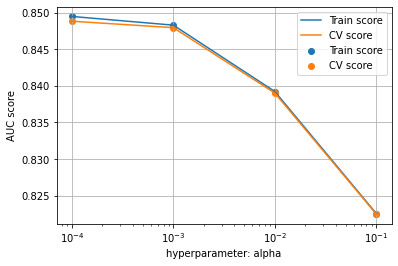

In [51]:
train_loss = clf.cv_results_['mean_train_score']
cv_loss = clf.cv_results_['mean_test_score']
plt.plot(parameter['alpha'], train_loss, label='Train score')
plt.plot(parameter['alpha'], cv_loss, label='CV score')

plt.scatter(parameter['alpha'], train_loss, label='Train score')
plt.scatter(parameter['alpha'], cv_loss, label='CV score')
plt.xscale('log')

plt.legend()
plt.xlabel('hyperparameter: alpha')
plt.ylabel("AUC score")
plt.grid()
plt.show()

### Linear SVM classifier using SGD

In [52]:
sgd = SGDClassifier(loss = 'hinge', class_weight = 'balanced') 
parameter = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
clf = GridSearchCV(sgd, parameter, cv = 5, scoring = 'roc_auc', n_jobs = -1, 
                   return_train_score = True)
clf.fit(x_train_ohe, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='roc_auc')

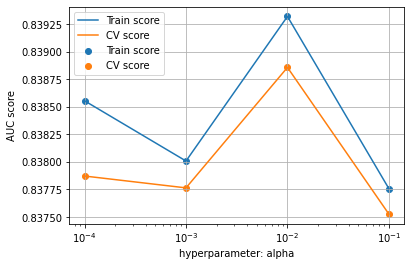

In [53]:
train_loss = clf.cv_results_['mean_train_score']
cv_loss = clf.cv_results_['mean_test_score']
plt.plot(parameter['alpha'], train_loss, label='Train score')
plt.plot(parameter['alpha'], cv_loss, label='CV score')

plt.scatter(parameter['alpha'], train_loss, label='Train score')
plt.scatter(parameter['alpha'], cv_loss, label='CV score')
plt.xscale('log')

plt.legend()
plt.xlabel('hyperparameter: alpha')
plt.ylabel("AUC score")
plt.grid()
plt.show()

### Logistic Regression with default parameters

In [54]:
from sklearn.metrics import roc_auc_score

sgd_clf = SGDClassifier(loss = 'log', class_weight= 'balanced', random_state = 12)
sgd_clf.fit(x_train_ohe, y_train)
sig_clf = CalibratedClassifierCV(sgd_clf, method = "sigmoid")
sig_clf.fit(x_train_ohe, y_train)

y_pred_train = sig_clf.predict_proba(x_train_ohe)
y_pred_test = sig_clf.predict_proba(x_test_ohe)

print("Train Score:", roc_auc_score(y_train, y_pred_train[:, 1]))

Train Score: 0.8495466780755871


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_val_score,KFold

In [61]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([334399,  46710]))

In [65]:
x_train,x_val,y_train,y_val = train_test_split(x_train_ohe,y_train_all,test_size = 0.30 ,random_state = 5)

### Baseline Model

In [ ]:
lr=LogisticRegression(solver="liblinear", random_state=5)

lr.fit(x_train,y_train)

In [ ]:
models=[]
models.append(('LogisticRegression',LogisticRegression(solver="liblinear", random_state=5)))
models.append(('DecisionTree',DecisionTreeClassifier(random_state=5)))
models.append(('RandomForest',RandomForestClassifier(random_state=5)))
models.append(('knn',KNeighborsClassifier()))

In [ ]:
results=[]
names=[]
for name,model in models:   
    kf=KFold(n_splits=5,shuffle=True,random_state=5)
    cv_score=cross_val_score(model,x_train,y_train,cv=kf,scoring='roc_auc',verbose=1)
    results.append(cv_score)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_score.mean(), cv_score.std())
    print(msg)

### Handling unbalanced dataset